In [21]:
import mne
import os

subject =  'pilot12'
session = '02'
folder = fr'C:\Users\moyne\Documents\NFB\data\sub-{subject}\ses-{session}\eeg'

tmin = 0
tmax = 0
raws = list()



metadatas = list()
for file in os.listdir(folder):
    if file.endswith('.fif'):
        file_path = os.path.join(folder, file)
        raw = mne.io.read_raw_fif(file_path)
        raw.pick_types(eeg=True, stim=False)
        metadata = dict()
        metadata['subject'] = file.split('_')[0].split('-')[1]
        metadata['session'] = file.split('_')[1].split('-')[1]
        metadata['task'] = file.split('_')[2].split('-')[1]
        metadata['run'] = file.split('_')[3].split('-')[1]
        if metadata['task'] in ['baseline', 'neurofeedback', 'restingstate', 'transfer']:
            tmin = tmax
            tmax = tmax + raw.times[-1]
            metadata['tmin'] = tmin
            metadata['tmax'] = tmax
            metadatas.append(metadata)
            raws.append(raw)


raw = mne.concatenate_raws(raws, preload=True)
raw.filter(1, 40)
raw.notch_filter([50, 100])

if 'PO10' in raw.ch_names:
    raw.rename_channels({'PO10': 'ecg'})
    raw.set_channel_types({'ecg': 'ecg'})
raw.set_montage('standard_1020')

C:\Users\moyne\AppData\Local\Temp\ipykernel_9800\243676314.py:34: RuntimeWarning: raw files do not all have the same data format, could result in precision mismatch. Setting raw.orig_format="unknown"
  raw = mne.concatenate_raws(raws, preload=True)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,34 points
Good channels,"31 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,ecg
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


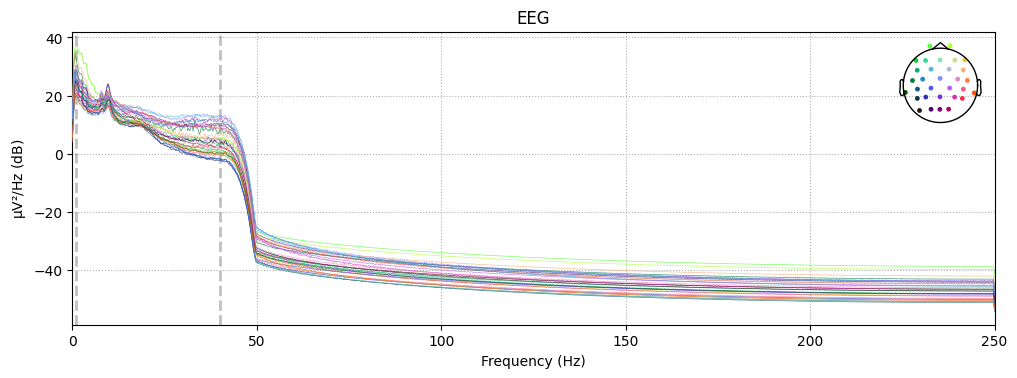

In [22]:
%matplotlib qt
raw.copy().set_eeg_reference('average').plot_psd()

In [23]:
raw.plot(precompute=False, scalings='auto')

In [5]:
raw.save(f'sub-{subject}_ses-{session}_annotated-raw.fif', overwrite=True)

Writing C:\Users\moyne\Documents\GitHub\neuxus_test\sub-pilot12_ses-02_annotated-raw.fif
Closing C:\Users\moyne\Documents\GitHub\neuxus_test\sub-pilot12_ses-02_annotated-raw.fif
[done]


In [24]:
from mne.preprocessing import ICA

rank = mne.compute_rank(raw)
ica = ICA(n_components=rank['eeg'], random_state=42, method='infomax', fit_params=dict(extended=True))
ica.fit(raw)

Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (1280871 samples)
ICA components,31
Available PCA components,31
Channel types,eeg
ICA components marked for exclusion,—


In [26]:
%matplotlib qt
ica.plot_components(inst=raw)

[<MNEFigure size 981x984 with 20 Axes>, <MNEFigure size 981x748 with 11 Axes>]

In [25]:
ica.plot_sources(inst=raw) #gbhfgh

In [27]:
raw_ica = ica.apply(raw.copy())
raw_ica.interpolate_bads()
raw_ica.set_eeg_reference('average')

C:\Users\moyne\AppData\Local\Temp\ipykernel_9800\534339631.py:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_ica.interpolate_bads()


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,34 points
Good channels,"31 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,ecg
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


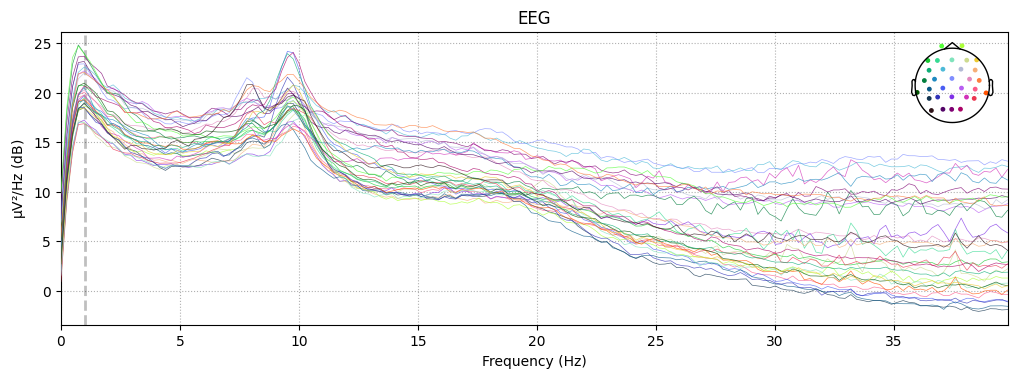

In [28]:
raw_ica.plot_psd(fmin=0, fmax=40)

In [11]:
raw_ica.save(fr'sub-{subject}_ses-{session}_annotated-preproc-raw.fif', overwrite=True)

Writing C:\Users\moyne\Documents\GitHub\neuxus_test\sub-pilot12_ses-02_annotated-preproc-raw.fif
Closing C:\Users\moyne\Documents\GitHub\neuxus_test\sub-pilot12_ses-02_annotated-preproc-raw.fif
[done]


In [96]:
metadatas

[{'subject': 'pilot12',
  'session': '02',
  'task': 'baseline',
  'run': '01',
  'tmin': 0,
  'tmax': 34.598,
  'alpha_power_right_dist': array([3.03453298e-11, 1.97700109e-11, 5.37592971e-11, 3.01057841e-11,
         9.19544506e-11, 4.82351710e-11, 2.14978232e-11, 2.69125705e-11,
         5.85600837e-11, 1.58313342e-11, 4.80234790e-11, 2.89218519e-11,
         2.81087312e-11, 3.41245502e-11, 4.31157966e-11, 2.60334628e-11,
         2.45392424e-11, 1.94705201e-11, 5.89178277e-11]),
  'alpha_power_left_dist': array([2.58592974e-11, 1.39522050e-11, 3.76878649e-11, 4.55618418e-11,
         2.25597639e-11, 3.02149143e-11, 2.12595572e-11, 1.92787948e-11,
         2.49000119e-11, 1.79042456e-11, 1.49679038e-11, 2.12950352e-11,
         1.48655999e-11, 1.64779016e-11, 2.14709234e-11, 2.46948628e-11,
         2.04058185e-11, 1.04095697e-11, 4.41902645e-11]),
  'alpha_power_right': 3.727512193181855e-11,
  'alpha_power_left': 2.3576651373612813e-11},
 {'subject': 'pilot12',
  'session': '02',


In [118]:
## Topomaps
import mne
import numpy as np

bands = {'alpha': (8, 13)}

# All runs
idx = ['restingstate_EO']
for i in range(15):
    i_ = i+1
    idx.append(f'baseline_{i_:02d}')
    idx.append(f'neurofeedback_{i_:02d}')


fig, axes = plt.subplots(1, len(idx), figsize=(30, 5))

m = 0
for index in idx:
    task, run = index.split('_')
    print(task, run)
    for met in metadatas:
        cmap = 'Reds' if task == 'baseline' else 'Blues' if task == 'neurofeedback' else 'Greens'
        if met['task'] != 'restingstate':
            if (met['task'] == task) and (met['run'] == run):
                metadata = met
                ax = axes[m]
                raw_ = raw_ica.copy().crop(metadata['tmin'], metadata['tmax'])
                psd = raw_.compute_psd(fmin=freqs[0], fmax=freqs[1])
                data = np.mean(psd.get_data(), axis=1)
                mne.viz.plot_topomap(data, raw_.info, axes=ax, cmap=cmap)
        else:
            metadata = met
            ax = axes[m]
            metadata['run'] = 'EO'
            raw_ = raw_ica.copy().crop(metadata['tmin'], metadata['tmin'] + 180)
            psd = raw_.compute_psd(fmin=freqs[0], fmax=freqs[1])
            data = np.mean(psd.get_data(), axis=1)
            mne.viz.plot_topomap(data, raw_.info, axes=ax, cmap=cmap)
    m += 1    
    del metadata


restingstate EO
baseline 01
neurofeedback 01
baseline 02
neurofeedback 02
baseline 03
neurofeedback 03
baseline 04
neurofeedback 04
baseline 05
neurofeedback 05
baseline 06
neurofeedback 06
baseline 07
neurofeedback 07
baseline 08
neurofeedback 08
baseline 09
neurofeedback 09
baseline 10
neurofeedback 10
baseline 11
neurofeedback 11
baseline 12
neurofeedback 12
baseline 13
neurofeedback 13
baseline 14
neurofeedback 14
baseline 15
neurofeedback 15


In [129]:
for met in metadatas:
    print(met['task'], met['run'])
            

baseline 01
baseline 02
baseline 03
baseline 04
baseline 05
baseline 06
baseline 07
baseline 08
baseline 09
baseline 10
baseline 11
baseline 12
baseline 13
baseline 14
baseline 15
neurofeedback 01
neurofeedback 02
neurofeedback 03
neurofeedback 04
neurofeedback 05
neurofeedback 06
neurofeedback 07
neurofeedback 08
neurofeedback 09
neurofeedback 10
neurofeedback 11
neurofeedback 12
restingstate EO
transfer 01
transfer 02
transfer 03


In [134]:
## Topomaps
import mne
import numpy as np

bands = {'alpha': (8, 13)}
# Get RS topomap

for metadata in metadatas:
    if metadata['task'] == 'restingstate':
        raw_ = raw_ica.copy().crop(metadata['tmin'], metadata['tmin'] + 180)
        psd = raw_.compute_psd(fmin=freqs[0], fmax=freqs[1])
        data_ref = np.mean(psd.get_data(), axis=1)

# All runs
idx = ['baseline_01',
        'neurofeedback_01',
        'baseline_02',
        'neurofeedback_02',
        'baseline_03',
        'neurofeedback_03',
        'baseline_04',
        'neurofeedback_04',
        'baseline_05',
        'neurofeedback_05',
        'baseline_06',
        'neurofeedback_06',
        'baseline_07',
        'neurofeedback_07',
        'baseline_08',
        'neurofeedback_08',
        'baseline_09',
        'neurofeedback_09',
        'baseline_10',
        'transfer_01',
        'baseline_11',
        'transfer_02',
        'baseline_12',
        'transfer_03',
        'baseline_13',
        'neurofeedback_10',
        'baseline_14',
        'neurofeedback_11',
        'baseline_15',
        'neurofeedback_12']


fig, axes = plt.subplots(1, len(idx), figsize=(30, 5))

m = 0
for index in idx:
    task, run = index.split('_')
    cmap = 'BrBG' if task == 'baseline' else 'RdBu' if task == 'neurofeedback' else 'PuOr'
    print(task, run)
    for metadata in metadatas:
        if (metadata['task'] == task) and (metadata['run'] == run):
            ax = axes[m]
            raw_ = raw_ica.copy().crop(metadata['tmin'], metadata['tmax'])
            psd = raw_.compute_psd(fmin=freqs[0], fmax=freqs[1])
            data = np.mean(psd.get_data(), axis=1) - data_ref
            mne.viz.plot_topomap(data, raw_.info, axes=ax, cmap=cmap)
            del metadata
    m += 1    

baseline 01
neurofeedback 01
baseline 02
neurofeedback 02
baseline 03
neurofeedback 03
baseline 04
neurofeedback 04
baseline 05
neurofeedback 05
baseline 06
neurofeedback 06
baseline 07
neurofeedback 07
baseline 08
neurofeedback 08
baseline 09
neurofeedback 09
baseline 10
transfer 01
baseline 11
transfer 02
baseline 12
transfer 03
baseline 13
neurofeedback 10
baseline 14
neurofeedback 11
baseline 15
neurofeedback 12


In [48]:
import mne
import numpy as np
# Define the electrodes of interest
electrodes_OI_right = ['P4', 'P8', 'O2']
electrodes_OI_left = ['P3', 'P7', 'O1']
freqs = [8, 13]
# Compute the alpha power on average for the specified electrodes
duration = 2

psds = list()
for metadata in metadatas:
    if metadata['task'] != 'restingstate':
        raw_ = raw_ica.copy().crop(metadata['tmin'], metadata['tmax'])
        epochs_ = mne.make_fixed_length_epochs(raw_, duration=duration, overlap=0.5, preload=False)
        epochs_ = epochs_.drop_bad()
        if len(epochs_):
            tf = mne.time_frequency.psd_array_welch(epochs_.get_data( picks=electrodes_OI_right), raw.info['sfreq'], fmin=freqs[0], fmax=freqs[1],)
            alpha_power_right = np.average(np.average(tf[0], axis=2), axis=1)
        
            tf = mne.time_frequency.psd_array_welch(epochs_.get_data( picks=electrodes_OI_left), raw.info['sfreq'], fmin=freqs[0], fmax=freqs[1],)
            alpha_power_left = np.average(np.average(tf[0], axis=2), axis=1)
        
            metadata['alpha_power_right_dist'] = alpha_power_right
            metadata['alpha_power_left_dist'] = alpha_power_left
            metadata['alpha_power_right'] = np.average(alpha_power_right)
            metadata['alpha_power_left'] = np.average(alpha_power_left)
            
            for right, left  in zip(alpha_power_right, alpha_power_left):
                p = {'power': right - left,
                    'side': 'right - left',
                     'run': metadata['run'],
                     'task': metadata['task']}
                psds.append(p)
    else:
        # EO
        metadata['run'] = 'EO'
        raw_ = raw_ica.copy().crop(metadata['tmin'], metadata['tmin'] + 180)
        epochs_ = mne.make_fixed_length_epochs(raw_, duration=duration, overlap=0.5, preload=False)
        epochs_ = epochs_.drop_bad()
        if len(epochs_):
            tf = mne.time_frequency.psd_array_welch(epochs_.get_data( picks=electrodes_OI_right), raw.info['sfreq'], fmin=freqs[0], fmax=freqs[1],)
            alpha_power_right = np.average(np.average(tf[0], axis=2), axis=1)
        
            tf = mne.time_frequency.psd_array_welch(epochs_.get_data( picks=electrodes_OI_left), raw.info['sfreq'], fmin=freqs[0], fmax=freqs[1],)
            alpha_power_left = np.average(np.average(tf[0], axis=2), axis=1)
        
            metadata['alpha_power_right_dist'] = alpha_power_right
            metadata['alpha_power_left_dist'] = alpha_power_left
            metadata['alpha_power_right'] = np.average(alpha_power_right)
            metadata['alpha_power_left'] = np.average(alpha_power_left)
            
            for right, left  in zip(alpha_power_right, alpha_power_left):
                p = {'power': right - left,
                     'side': 'right - left',
                     'run': metadata['run'],
                     'task': metadata['task']}
                psds.append(p)
                
        # EC
        metadata['run'] = 'EC'
        raw_ = raw_ica.copy().crop(metadata['tmin'] + 180, metadata['tmax'])
        epochs_ = mne.make_fixed_length_epochs(raw_, duration=duration, overlap=0.5, preload=False)
        epochs_ = epochs_.drop_bad()
        if len(epochs_):
            tf = mne.time_frequency.psd_array_welch(epochs_.get_data( picks=electrodes_OI_right), raw.info['sfreq'], fmin=freqs[0], fmax=freqs[1],)
            alpha_power_right = np.average(np.average(tf[0], axis=2), axis=1)
        
            tf = mne.time_frequency.psd_array_welch(epochs_.get_data( picks=electrodes_OI_left), raw.info['sfreq'], fmin=freqs[0], fmax=freqs[1],)
            alpha_power_left = np.average(np.average(tf[0], axis=2), axis=1)
        
            metadata['alpha_power_right_dist'] = alpha_power_right
            metadata['alpha_power_left_dist'] = alpha_power_left
            metadata['alpha_power_right'] = np.average(alpha_power_right)
            metadata['alpha_power_left'] = np.average(alpha_power_left)
            
            for right, left  in zip(alpha_power_right, alpha_power_left):
                p = {'power': right - left,
                     'side': 'right - left',
                     'run': metadata['run'],
                     'task': metadata['task']}
                psds.append(p)

In [50]:
import pandas as pd
df = pd.DataFrame(psds)

def new(row):
    run = row['run']
    task = row['task']
    if task == 'neurofeedback':
        if run == '10':
            run = '13'
        elif run == '11':
            run = '14'       
        elif run == '12':
            run = '15'
    elif task == 'transfer':
        task = 'neurofeedback'
        if run == '01':
            run = '10'
        elif run == '02':
            run = '11'       
        elif run == '03':
            run = '12'
    return(task, run)

df[['new_task', 'new_run']] = [new(row) for r, row in df.iterrows()]
df['task_run'] = df['new_task'] + '_' + df['new_run']
df

,power,side,run,task,new_task,new_run,task_run
0,4.486032e-12,right - left,01,baseline,baseline,01,baseline_01
1,5.817806e-12,right - left,01,baseline,baseline,01,baseline_01
2,1.607143e-11,right - left,01,baseline,baseline,01,baseline_01
3,-1.545606e-11,right - left,01,baseline,baseline,01,baseline_01
4,6.939469e-11,right - left,01,baseline,baseline,01,baseline_01
...,...,...,...,...,...,...,...
1622,8.071748e-13,right - left,03,transfer,neurofeedback,12,neurofeedback_12
1623,-2.351999e-12,right - left,03,transfer,neurofeedback,12,neurofeedback_12
1624,3.165717e-11,right - left,03,transfer,neurofeedback,12,neurofeedback_12
1625,3.232991e-12,right - left,03,transfer,neurofeedback,12,neurofeedback_12


In [135]:
# All runs
idx = ['restingstate_EO', 'restingstate_EC']
for i in range(15):
    i_ = i+1
    idx.append(f'baseline_{i_:02d}')
    idx.append(f'neurofeedback_{i_:02d}')

baseline_repeated_measures = dabest.load(df,
                                         idx=idx,
                                         x="task_run",
                                         y="power")

mean_rest_power = df[df['task_run'] == 'restingstate_EO']['power'].mean()

fig, ax = plt.subplots()
baseline_repeated_measures.mean_diff.plot(color_col='task', ax=ax)
ax.set_title( f'Restingstate power: {mean_rest_power} ({df["side"].values[0]})')

C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 93.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 91.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 89.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 93.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings

Text(0.5, 1.0, 'Restingstate power: 1.5445360818359315e-11 (right - left)')

In [136]:
# All runs
idx = ['restingstate_EO']
for i in range(15):
    i_ = i+1
    idx.append(f'neurofeedback_{i_:02d}')

baseline_repeated_measures = dabest.load(df,
                                         idx=idx,
                                         x="task_run",
                                         y="power")

mean_rest_power = df[df['task_run'] == 'restingstate_EO']['power'].mean()

fig, ax = plt.subplots()
baseline_repeated_measures.mean_diff.plot(color_col='task', ax=ax)
ax.set_title( f'Restingstate power: {mean_rest_power} ({df["side"].values[0]})')

C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 83.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 82.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 85.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 82.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings

Text(0.5, 1.0, 'Restingstate power: 1.5445360818359315e-11 (right - left)')

C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 56.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\moyne\AppData\Local\miniconda3\envs\nf_analysis\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings

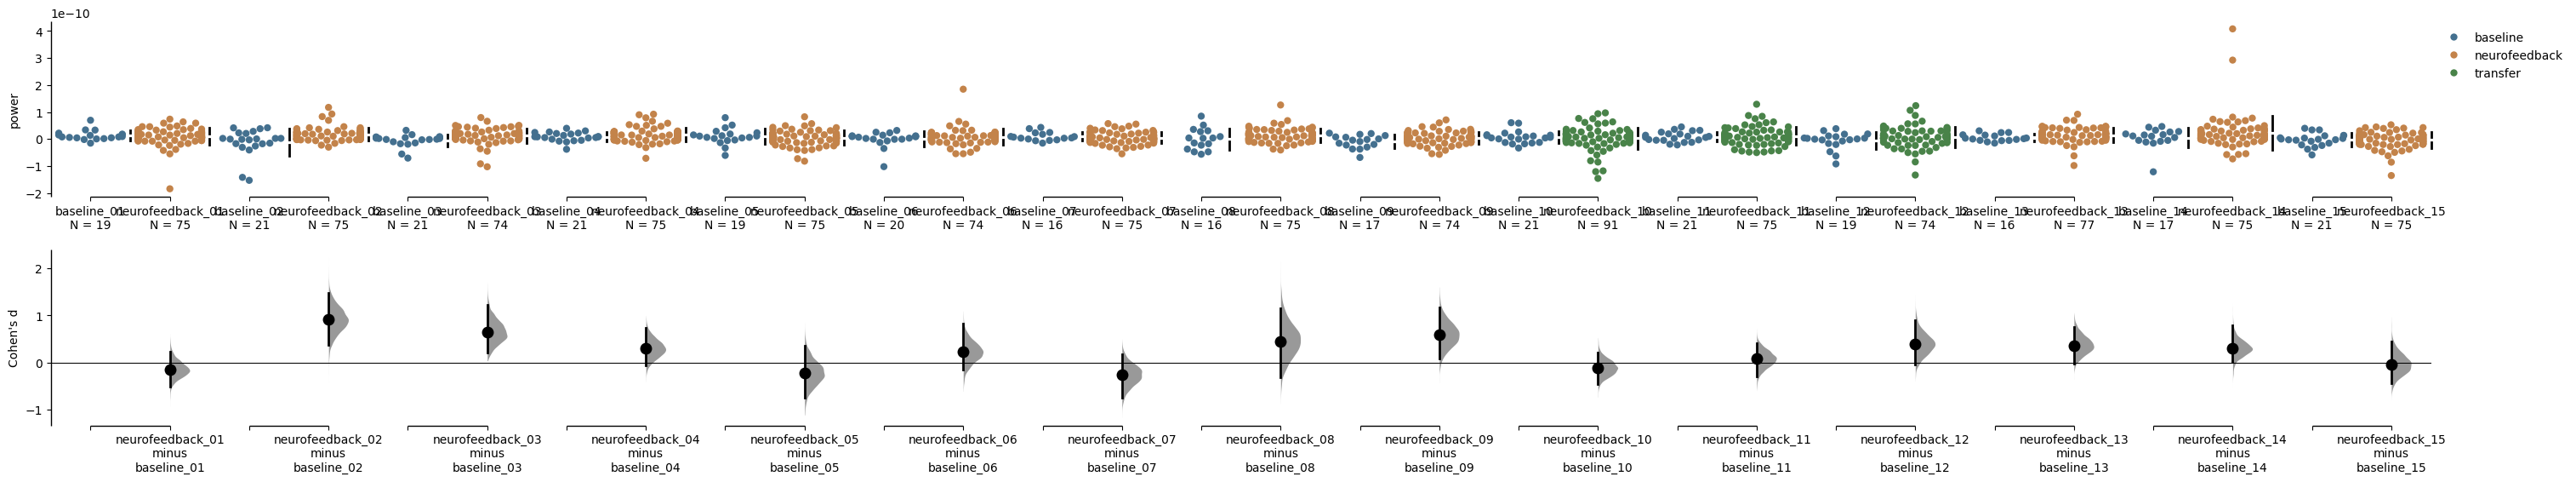

In [52]:
import dabest
import matplotlib.pyplot as plt

runs_nf = df[df['new_task'] == 'neurofeedback']['new_run'].unique()
runs_baseline = df[df['new_task'] == 'baseline']['new_run'].unique()
runs = np.intersect1d(runs_nf, runs_baseline)
runs.sort()
idx = [(f"baseline_{i}", f"neurofeedback_{i}") for i in runs]

unpaired = dabest.load(data = df,
                          idx=idx,
                          x="task_run", y="power")

unpaired.cohens_d.plot(color_col='task')

In [15]:
import seaborn as sns

order = df[df['new_task'] == 'neurofeedback']['task_run'].unique()
order.sort()
xticks_labels = [o.split('_')[-1] for o in order]
xticks = np.arange(len(xticks_labels))

fig, ax = plt.subplots()
sns.boxplot(data=df, x='task_run', y='power',order=order, ax=ax)
ax.set_xticks(xticks, xticks_labels)

ax.hlines(y=0, xmin=-1, xmax=xticks.max()+1, color='red')

plt.show()